# Texas Housing Time Analysis
__By: Brian Lee__
***

## Business problem:

Housing agents would like to see the next best metropolis to invest in based on the average housing price increases over the last few years. This will allow for the housing agency to better expect price jumps early, allowing for earlier buys at lower prices and selling at higher prices.
Forecast model for TX

As multiple markets like the streaming and tech companies are interested in Texas due to relatively low housing prices and no income tax. 

## Data Preparation

In [1]:
# Import necessary packages
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
plt.style.use('seaborn-whitegrid')

import warnings
warnings.filterwarnings('ignore')
import itertools
import statsmodels.api as sm

In [2]:
df = pd.read_csv('time-series/zillow_data.csv')
df.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,236900.0,236700.0,...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
2,91982,77494,Katy,TX,Houston,Harris,3,210400.0,212200.0,212200.0,...,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900
3,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0,500900.0,503100.0,...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
4,93144,79936,El Paso,TX,El Paso,El Paso,5,77300.0,77300.0,77300.0,...,119100,119400,120000,120300,120300,120300,120300,120500,121000,121500


In [3]:
# Extract only Texas data values
TX_df = df[df['State'] == 'TX']
TX_df.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,236900.0,236700.0,...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
2,91982,77494,Katy,TX,Houston,Harris,3,210400.0,212200.0,212200.0,...,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900
4,93144,79936,El Paso,TX,El Paso,El Paso,5,77300.0,77300.0,77300.0,...,119100,119400,120000,120300,120300,120300,120300,120500,121000,121500
5,91733,77084,Houston,TX,Houston,Harris,6,95000.0,95200.0,95400.0,...,157900,158700,160200,161900,162800,162800,162800,162900,163500,164300
8,91940,77449,Katy,TX,Houston,Harris,9,95400.0,95600.0,95800.0,...,166800,167400,168400,169600,170900,172300,173300,174200,175400,176200


In [4]:
# Houston dataset
houston_df = TX_df[TX_df['Metro'] == 'Houston']

****

We will use __Return on Investment (ROI)__ in order to determine whether the home value in the area is best for the model.

Calculated (Final Value - Initial Value) / Cost of Investment

In [5]:
# 5 year ROI
houston_df['ROI_5_years'] = round((houston_df['2018-04'] - houston_df['2013-01'])/ houston_df['2013-01'],4)

# 3 year ROI
houston_df['ROI_10_years'] = round((houston_df['2018-04'] - houston_df['2008-01'])/ houston_df['2008-01'],4)

houston_df.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,ROI_5_years,ROI_10_years
2,91982,77494,Katy,TX,Houston,Harris,3,210400.0,212200.0,212200.0,...,320200,320400,320800,321200,321200,323000,326900,329900,0.2842,0.2983
5,91733,77084,Houston,TX,Houston,Harris,6,95000.0,95200.0,95400.0,...,160200,161900,162800,162800,162800,162900,163500,164300,0.4617,0.2494
8,91940,77449,Katy,TX,Houston,Harris,9,95400.0,95600.0,95800.0,...,168400,169600,170900,172300,173300,174200,175400,176200,0.5021,0.2908
22,92036,77573,League City,TX,Houston,Galveston,23,141400.0,141000.0,140600.0,...,252300,252400,252300,253100,254700,257100,259800,261400,0.4130,0.3189
23,92045,77584,Pearland,TX,Houston,Brazoria,24,138500.0,138700.0,139200.0,...,250500,250700,251000,251400,251900,253200,255100,256500,0.3783,0.2749


In [6]:
# Reshape from Wide to Long Format
def melt_data(df):
    melted = pd.melt(df, id_vars=['RegionName', 'City', 'CountyName', 'ROI_5_years', 'ROI_10_years'], var_name='Date')
    melted['Date'] = pd.to_datetime(melted['Date'], infer_datetime_format=True)
    melted = melted.dropna(subset=['value'])
    return melted

In [7]:
# Remove unnecessary columns
houston_df.drop(columns=['RegionID','State','Metro','SizeRank'], inplace=True)

In [8]:
houston_df.head()

,RegionName,City,CountyName,1996-04,1996-05,1996-06,1996-07,1996-08,1996-09,1996-10,...,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,ROI_5_years,ROI_10_years
2,77494,Katy,Harris,210400.0,212200.0,212200.0,210700.0,208300.0,205500.0,202500.0,...,320200,320400,320800,321200,321200,323000,326900,329900,0.2842,0.2983
5,77084,Houston,Harris,95000.0,95200.0,95400.0,95700.0,95900.0,96100.0,96200.0,...,160200,161900,162800,162800,162800,162900,163500,164300,0.4617,0.2494
8,77449,Katy,Harris,95400.0,95600.0,95800.0,96100.0,96400.0,96700.0,96800.0,...,168400,169600,170900,172300,173300,174200,175400,176200,0.5021,0.2908
22,77573,League City,Galveston,141400.0,141000.0,140600.0,140500.0,140400.0,140500.0,140700.0,...,252300,252400,252300,253100,254700,257100,259800,261400,0.4130,0.3189
23,77584,Pearland,Brazoria,138500.0,138700.0,139200.0,139900.0,140700.0,141600.0,142500.0,...,250500,250700,251000,251400,251900,253200,255100,256500,0.3783,0.2749


In [9]:
houston_df.isna().sum().sort_values(ascending=False)

ROI_10_years    0
2003-01         0
2004-03         0
2004-02         0
2004-01         0
               ..
2010-07         0
2010-06         0
2010-05         0
2010-04         0
RegionName      0
Length: 270, dtype: int64

In [10]:
melt_df = melt_data(houston_df)
melt_df.head()

,RegionName,City,CountyName,ROI_5_years,ROI_10_years,Date,value
0,77494,Katy,Harris,0.2842,0.2983,1996-04-01,210400.0
1,77084,Houston,Harris,0.4617,0.2494,1996-04-01,95000.0
2,77449,Katy,Harris,0.5021,0.2908,1996-04-01,95400.0
3,77573,League City,Galveston,0.4130,0.3189,1996-04-01,141400.0
4,77584,Pearland,Brazoria,0.3783,0.2749,1996-04-01,138500.0


In [11]:
melt_df.rename(columns = {"RegionName": "Zipcode", "CountyName": "County", "time": "Date", "value": "Price"}, inplace=True)
melt_df.head()

,Zipcode,City,County,ROI_5_years,ROI_10_years,Date,Price
0,77494,Katy,Harris,0.2842,0.2983,1996-04-01,210400.0
1,77084,Houston,Harris,0.4617,0.2494,1996-04-01,95000.0
2,77449,Katy,Harris,0.5021,0.2908,1996-04-01,95400.0
3,77573,League City,Galveston,0.4130,0.3189,1996-04-01,141400.0
4,77584,Pearland,Brazoria,0.3783,0.2749,1996-04-01,138500.0


In [12]:
# Zipcode type to string
melt_df['Zipcode'] = melt_df['Zipcode'].astype(str)

# 'Date' column to datetime format
melt_df['Date'] = pd.to_datetime(melt_df['Date'], format='%m/%y')

# 'Date' column as dataframe index
melt_df.set_index('Date', inplace=True)

In [13]:
melt_df

,Zipcode,City,County,ROI_5_years,ROI_10_years,Price
Date,,,,,,
1996-04-01,77494,Katy,Harris,0.2842,0.2983,210400.0
1996-04-01,77084,Houston,Harris,0.4617,0.2494,95000.0
1996-04-01,77449,Katy,Harris,0.5021,0.2908,95400.0
1996-04-01,77573,League City,Galveston,0.4130,0.3189,141400.0
1996-04-01,77584,Pearland,Brazoria,0.3783,0.2749,138500.0
...,...,...,...,...,...,...
2018-04-01,77514,Anahuac,Chambers,0.3933,0.2795,136400.0
2018-04-01,77050,Houston,Harris,0.5695,0.2468,115200.0
2018-04-01,77650,Port Bolivar,Galveston,0.2758,0.1968,247500.0


In [14]:
# Double Check for missing values
melt_df.isna().sum()

Zipcode         0
City            0
County          0
ROI_5_years     0
ROI_10_years    0
Price           0
dtype: int64

## EDA and Visualization

__Questions we can ask:__
1. How have Houston housing prices generally trended over time?
2. Which zipcodes in Houston have the highest prices?
3. Which 

### How have Texas housing prices generally trended over time?

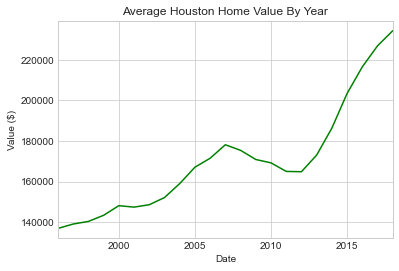

In [15]:
yearly_df = melt_df['Price'].resample(rule='A').mean()
yearly_df.plot.line(color='green')
plt.title('Average Houston Home Value By Year')
plt.ylabel('Value ($)')
plt.show()

* Outside of the dip in housing prices between 2007 and 2011, the average price of a Texas home has __steadily increased__.
***

### Which counties have higher home prices?

In [16]:
county_df = melt_df.copy()
county_df = county_df.groupby('County').Price.mean().sort_values(ascending=False).head(10)

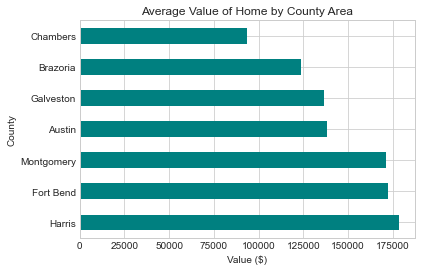

In [17]:
county_df.plot.barh(color='teal')
plt.title('Average Value of Home by County Area')
plt.xlabel('Value ($)')
plt.show()

* __Harris, Fort Bend, and Montgomery__ have clearly the highest average home values in the past 20 years.
___

### Which counties have the highest ROIs?

In [28]:
# 5 year ROI
ROI_5_df = melt_df.copy()
ROI_5_df = ROI_5_df.groupby('County').ROI_5_years.mean().sort_values(ascending=False).head(10)

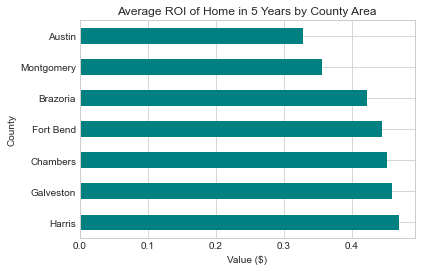

In [29]:
ROI_5_df.plot.barh(color='teal')
plt.title('Average ROI of Home in 5 Years by County Area')
plt.xlabel('Value ($)')
plt.show()

In [26]:
# 10 year ROI
ROI_10_df = melt_df.copy()
ROI_10_df = ROI_10_df.groupby('County').ROI_10_years.mean().sort_values(ascending=False).head(10)

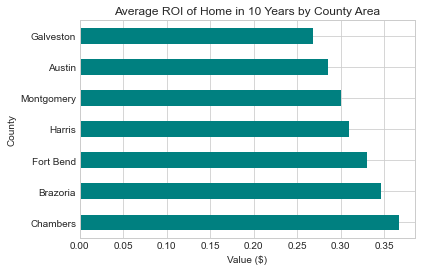

In [27]:
ROI_10_df.plot.barh(color='teal')
plt.title('Average ROI of Home in 10 Years by County Area')
plt.xlabel('Value ($)')
plt.show()

### Which Zipcodes in Houston have the highest home prices?

In [18]:
zip_df = melt_df.copy()
zip_df = zip_df.groupby('Zipcode').Price.mean().sort_values(ascending=False).head(10)

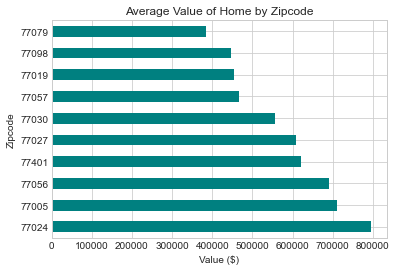

In [19]:
zip_df.plot.barh(color='teal')
plt.title('Average Value of Home by Zipcode')
plt.xlabel('Value ($)')
plt.show()

* __77024__ appears to be the zipcode with the Highest average home value in the past 20 years.
***

## Time Series Modeling

Using SARIMA model. Need to check for stationary.

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from pandas.plotting import autocorrelation_plot,lag_plot

def plot_autocorr(ts, figsize=(10,8),lags=24):
    
    fig,ax = plt.subplots(nrows=3,figsize=figsize)
    
    ## Plot ts
    ts.plot(ax=ax[0])
    
    ## Plot acf, pavf
    plot_acf(ts,ax=ax[1],lags=lags)
    plot_pacf(ts, ax=ax[2],lags=lags) 
    fig.tight_layout()
    
    fig.suptitle(f"Zipcode: {ts.name}",y=1.1,fontsize=20)
    
    for a in ax[1:]:
        a.xaxis.set_major_locator(mpl.ticker.MaxNLocator(min_n_ticks=lags, integer=True))
        a.xaxis.grid()
        
    return fig,ax

# Step 6: Interpreting Results